<a href="https://colab.research.google.com/github/armandoordonez/machinelearning/blob/main/PCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Principal Components Regression PCR consiste en ajustar un modelo de regresión lineal por mínimos cuadrados empleando como predictores las componentes generadas a partir de un Principal Component Analysis (PCA). 

In [14]:
# Basado en https://www.cienciadedatos.net/documentos/py19-pca-python.html

# Tratamiento de datos

# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Datos
# se mide el espectro de absorbancia a 100 longitudes de onda en 215 muestras de carne, 
# cuyo contenido en grasa se obtiene también por análisis químico, 
# Se busca entrenar un modelo con el objetivo de predecir el contenido en grasa a partir de los valores dados por el espectrofotómetro
# ==============================================================================
datos = pd.read_csv('train.csv')
#datos = pd.merge(datos,pd.read_csv('test.csv'))
datos = datos.drop(columns = datos.columns[0])



In [16]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [17]:
non_categorical = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", 
                   "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", 
                   "2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea", 
                   "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", 
                   "ScreenPorch","PoolArea", "MiscVal","SalePrice"]

categorical = [value for value in datos if value not in non_categorical]

datos = datos.drop(columns=categorical)

In [18]:
datos=datos.dropna()
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1195 entries, 0 to 1459
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    1195 non-null   float64
 1   LotArea        1195 non-null   int64  
 2   MasVnrArea     1195 non-null   float64
 3   BsmtFinSF1     1195 non-null   int64  
 4   BsmtFinSF2     1195 non-null   int64  
 5   BsmtUnfSF      1195 non-null   int64  
 6   TotalBsmtSF    1195 non-null   int64  
 7   1stFlrSF       1195 non-null   int64  
 8   2ndFlrSF       1195 non-null   int64  
 9   LowQualFinSF   1195 non-null   int64  
 10  GrLivArea      1195 non-null   int64  
 11  GarageArea     1195 non-null   int64  
 12  WoodDeckSF     1195 non-null   int64  
 13  OpenPorchSF    1195 non-null   int64  
 14  EnclosedPorch  1195 non-null   int64  
 15  3SsnPorch      1195 non-null   int64  
 16  ScreenPorch    1195 non-null   int64  
 17  PoolArea       1195 non-null   int64  
 18  MiscVal 

In [19]:
# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = datos.select_dtypes(include=['float64', 'int']) \
              .corr(method='pearson')
display(tidy_corr_matrix(corr_matrix).head(10))



,variable_1,variable_2,r,abs_r
127,TotalBsmtSF,1stFlrSF,0.831958,0.831958
146,1stFlrSF,TotalBsmtSF,0.831958,0.831958
390,SalePrice,GrLivArea,0.704448,0.704448
219,GrLivArea,SalePrice,0.704448,0.704448
170,2ndFlrSF,GrLivArea,0.691980,0.691980
208,GrLivArea,2ndFlrSF,0.691980,0.691980
391,SalePrice,GarageArea,0.630611,0.630611
239,GarageArea,SalePrice,0.630611,0.630611
386,SalePrice,TotalBsmtSF,0.625333,0.625333
139,TotalBsmtSF,SalePrice,0.625333,0.625333


In [20]:
# # (correlación absoluta > 0.8), lo que supone un problema a la hora de emplear modelos de regresión lineal

# División de los datos en train y test
# ==============================================================================
X = datos.drop(columns='SalePrice')
y = datos['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

Se ajustan dos modelos lineales, uno con todos los predictores y otro con solo algunas de las componentes obtenidas por PCA, con el objetivo de identificar cuál de ellos es capaz de predecir mejor el contenido en grasa de la carne en función de las señales registradas por el espectrofotómetro.



In [21]:
# Creación y entrenamiento del modelo
# ==============================================================================
modelo = LinearRegression()
modelo.fit(X = X_train, y = y_train)


LinearRegression()

In [22]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()

# Error de test del modelo 
# ==============================================================================
rmse_ols = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_ols}")


El error (rmse) de test es: 45577.0690756156


In [23]:
# Entrenamiento modelo de regresión precedido por PCA con escalado

# ==============================================================================

pipe_modelado = make_pipeline(StandardScaler(), PCA(), LinearRegression())

pipe_modelado.fit(X=X_train, y=y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('linearregression', LinearRegression())])

In [24]:
pipe_modelado.set_params

<bound method Pipeline.set_params of Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('linearregression', LinearRegression())])>

In [25]:
# Predicciones test
# ==============================================================================
predicciones = pipe_modelado.predict(X=X_test)
predicciones = predicciones.flatten()

# Error de test del modelo 
# ==============================================================================
rmse_pcr = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_pcr}")


El error (rmse) de test es: 46072.85659121156


In [26]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'pca__n_components': [1, 2, 4, 6, 8, 10, 15, 20, 30, 50]}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = pipe_modelado,
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = KFold(n_splits=5, random_state=123,shuffle=True), 
        refit      = True,
        verbose    = 0,
        return_train_score = True,
        

       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(3)

,param_pca__n_components,mean_test_score,std_test_score,mean_train_score,std_train_score
2,4,-51430.584574,10617.510237,-49148.613466,2921.610677
3,6,-51706.164670,10494.883503,-48669.224118,2751.287088
6,15,-51821.315388,9263.816770,-46279.192900,2078.197554


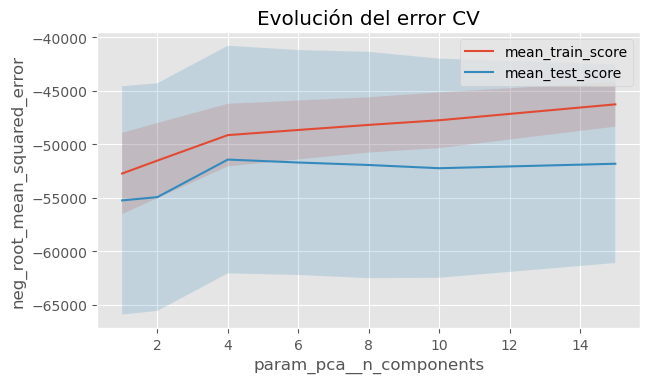

In [27]:
# Gráfico resultados validación cruzada para cada hiperparámetro
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.84), sharey=True)

resultados.plot('param_pca__n_components', 'mean_train_score', ax=ax)
resultados.plot('param_pca__n_components', 'mean_test_score', ax=ax)
ax.fill_between(resultados.param_pca__n_components.astype(np.float),
                resultados['mean_train_score'] + resultados['std_train_score'],
                resultados['mean_train_score'] - resultados['std_train_score'],
                alpha=0.2)
ax.fill_between(resultados.param_pca__n_components.astype(np.float),
                resultados['mean_test_score'] + resultados['std_test_score'],
                resultados['mean_test_score'] - resultados['std_test_score'],
                alpha=0.2)
ax.legend()
ax.set_title('Evolución del error CV')
ax.set_ylabel('neg_root_mean_squared_error');

In [28]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'pca__n_components': 4} : -51430.58457351011 neg_root_mean_squared_error


In [29]:
# Entrenamiento modelo de regresión precedido por PCA con escalado
# ==============================================================================
pipe_modelado = make_pipeline(StandardScaler(), PCA(n_components=5), LinearRegression())
pipe_modelado.fit(X=X_train, y=y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=5)),
                ('linearregression', LinearRegression())])

In [30]:
# Predicciones test
# ==============================================================================
predicciones = pipe_modelado.predict(X=X_test)
predicciones = predicciones.flatten()

# Error de test del modelo 
# ==============================================================================
rmse_pcr = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_pcr}")


El error (rmse) de test es: 44415.45422671169


In [31]:
# Based on: Análisis de componentes princiaples PCA con Python by Joaquín Amat Rodrigo, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/documentos/py19-pca-python.html

